# Classification Models for predicting Departure Delay
This notebook trains the below mentioned models.


1. Linear model(stochastic gradient descent (SGD) Classifier)
2. Linear model(Logistic regression)
3. Tree Based(Decision Tree Classifier)
4. Ensemble model(Random Forest Classifier)
5. Ensemble model(Gradient Boosting Classifier)
6. Naive_bayes model( GaussianNB model)






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection
from sklearn.metrics import roc_curve 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Data Preprocessing

In [3]:

df_flight = pd.read_csv("/content/drive/Shareddrives/255 Team Project/Flight Delay Dataset/flights.csv")
df_air = pd.read_csv('/content/drive/Shareddrives/255 Team Project/Flight Delay Dataset/airports.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


df_flight is a huge data, Taking this into consideration, Extracting the data for one month i.e. January Month 

In [4]:
df_flight = df_flight[df_flight['MONTH'] == 1]

In [5]:
df_flight.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_air.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


The most important column is the DEPARTURE_DELAY and column CANCELLED is also important considering the fact that when flights gets cancelled, there will be no delay . So, we take values in which flights are not cancelled.

In [7]:
df_flight.groupby('CANCELLED').size()

CANCELLED
0    457986
1     11982
dtype: int64

In [8]:
df_flight = df_flight.loc[df_flight.CANCELLED.isin([0])]

Setting DEPARTURE_DELAY as the target value and setting it to 1 when the delay is 0 or greater than 0. otherwise, 0.

In [9]:
df_flight['DEPARTURE_DELAY'] = (df_flight.DEPARTURE_DELAY > 0).astype('int') 

## Feature Engineering

### Dealing with Numerical features 

In [10]:
col_with_numerical_values = ['SCHEDULED_TIME','SCHEDULED_ARRIVAL','SCHEDULED_DEPARTURE','DAY_OF_WEEK']


In [11]:
df_flight[col_with_numerical_values].isnull().sum()

SCHEDULED_TIME         0
SCHEDULED_ARRIVAL      0
SCHEDULED_DEPARTURE    0
DAY_OF_WEEK            0
dtype: int64

### Dealing with categorical features

In [12]:
col_with_categorical_values = ['AIRLINE','ORIGIN_AIRPORT']


In [13]:
df_flight[col_with_categorical_values].isnull().sum()

AIRLINE           0
ORIGIN_AIRPORT    0
dtype: int64

One-hot encoding: We create a new feature for each unique value of the column , sets value to 1 if it is unique otherwise,0 using get_dummies function.

In [14]:
categorical_df = pd.get_dummies(df_flight[col_with_categorical_values],drop_first = True)

In [15]:
categorical_df.head()

,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN,ORIGIN_AIRPORT_ABI,ORIGIN_AIRPORT_ABQ,ORIGIN_AIRPORT_ABR,ORIGIN_AIRPORT_ABY,ORIGIN_AIRPORT_ACT,ORIGIN_AIRPORT_ACV,ORIGIN_AIRPORT_ACY,ORIGIN_AIRPORT_ADK,ORIGIN_AIRPORT_ADQ,ORIGIN_AIRPORT_AEX,ORIGIN_AIRPORT_AGS,ORIGIN_AIRPORT_ALB,ORIGIN_AIRPORT_ALO,ORIGIN_AIRPORT_AMA,ORIGIN_AIRPORT_ANC,ORIGIN_AIRPORT_APN,ORIGIN_AIRPORT_ASE,ORIGIN_AIRPORT_ATL,ORIGIN_AIRPORT_ATW,ORIGIN_AIRPORT_AUS,ORIGIN_AIRPORT_AVL,ORIGIN_AIRPORT_AVP,ORIGIN_AIRPORT_AZO,ORIGIN_AIRPORT_BDL,ORIGIN_AIRPORT_BET,ORIGIN_AIRPORT_BFL,ORIGIN_AIRPORT_BHM,...,ORIGIN_AIRPORT_SHV,ORIGIN_AIRPORT_SIT,ORIGIN_AIRPORT_SJC,ORIGIN_AIRPORT_SJT,ORIGIN_AIRPORT_SJU,ORIGIN_AIRPORT_SLC,ORIGIN_AIRPORT_SMF,ORIGIN_AIRPORT_SMX,ORIGIN_AIRPORT_SNA,ORIGIN_AIRPORT_SPI,ORIGIN_AIRPORT_SPS,ORIGIN_AIRPORT_SRQ,ORIGIN_AIRPORT_STC,ORIGIN_AIRPORT_STL,ORIGIN_AIRPORT_STT,ORIGIN_AIRPORT_STX,ORIGIN_AIRPORT_SUN,ORIGIN_AIRPORT_SUX,ORIGIN_AIRPORT_SWF,ORIGIN_AIRPORT_SYR,ORIGIN_AIRPORT_TLH,ORIGIN_AIRPORT_TOL,ORIGIN_AIRPORT_TPA,ORIGIN_AIRPORT_TRI,ORIGIN_AIRPORT_TTN,ORIGIN_AIRPORT_TUL,ORIGIN_AIRPORT_TUS,ORIGIN_AIRPORT_TVC,ORIGIN_AIRPORT_TWF,ORIGIN_AIRPORT_TXK,ORIGIN_AIRPORT_TYR,ORIGIN_AIRPORT_TYS,ORIGIN_AIRPORT_UST,ORIGIN_AIRPORT_VEL,ORIGIN_AIRPORT_VLD,ORIGIN_AIRPORT_VPS,ORIGIN_AIRPORT_WRG,ORIGIN_AIRPORT_XNA,ORIGIN_AIRPORT_YAK,ORIGIN_AIRPORT_YUM
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Adding the categorical dataframe to the Numerical dataframe to include the categorical data.

In [16]:
df_flight = pd.concat([df_flight,categorical_df], axis = 1)

In [17]:
input_parameters = col_with_numerical_values + list(categorical_df.columns)
df_complete_data = df_flight[input_parameters + ['DEPARTURE_DELAY']]
df_complete_data.head()

,SCHEDULED_TIME,SCHEDULED_ARRIVAL,SCHEDULED_DEPARTURE,DAY_OF_WEEK,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN,ORIGIN_AIRPORT_ABI,ORIGIN_AIRPORT_ABQ,ORIGIN_AIRPORT_ABR,ORIGIN_AIRPORT_ABY,ORIGIN_AIRPORT_ACT,ORIGIN_AIRPORT_ACV,ORIGIN_AIRPORT_ACY,ORIGIN_AIRPORT_ADK,ORIGIN_AIRPORT_ADQ,ORIGIN_AIRPORT_AEX,ORIGIN_AIRPORT_AGS,ORIGIN_AIRPORT_ALB,ORIGIN_AIRPORT_ALO,ORIGIN_AIRPORT_AMA,ORIGIN_AIRPORT_ANC,ORIGIN_AIRPORT_APN,ORIGIN_AIRPORT_ASE,ORIGIN_AIRPORT_ATL,ORIGIN_AIRPORT_ATW,ORIGIN_AIRPORT_AUS,ORIGIN_AIRPORT_AVL,ORIGIN_AIRPORT_AVP,ORIGIN_AIRPORT_AZO,...,ORIGIN_AIRPORT_SIT,ORIGIN_AIRPORT_SJC,ORIGIN_AIRPORT_SJT,ORIGIN_AIRPORT_SJU,ORIGIN_AIRPORT_SLC,ORIGIN_AIRPORT_SMF,ORIGIN_AIRPORT_SMX,ORIGIN_AIRPORT_SNA,ORIGIN_AIRPORT_SPI,ORIGIN_AIRPORT_SPS,ORIGIN_AIRPORT_SRQ,ORIGIN_AIRPORT_STC,ORIGIN_AIRPORT_STL,ORIGIN_AIRPORT_STT,ORIGIN_AIRPORT_STX,ORIGIN_AIRPORT_SUN,ORIGIN_AIRPORT_SUX,ORIGIN_AIRPORT_SWF,ORIGIN_AIRPORT_SYR,ORIGIN_AIRPORT_TLH,ORIGIN_AIRPORT_TOL,ORIGIN_AIRPORT_TPA,ORIGIN_AIRPORT_TRI,ORIGIN_AIRPORT_TTN,ORIGIN_AIRPORT_TUL,ORIGIN_AIRPORT_TUS,ORIGIN_AIRPORT_TVC,ORIGIN_AIRPORT_TWF,ORIGIN_AIRPORT_TXK,ORIGIN_AIRPORT_TYR,ORIGIN_AIRPORT_TYS,ORIGIN_AIRPORT_UST,ORIGIN_AIRPORT_VEL,ORIGIN_AIRPORT_VLD,ORIGIN_AIRPORT_VPS,ORIGIN_AIRPORT_WRG,ORIGIN_AIRPORT_XNA,ORIGIN_AIRPORT_YAK,ORIGIN_AIRPORT_YUM,DEPARTURE_DELAY
0,205.0,430,5,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,280.0,750,10,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,286.0,806,20,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,285.0,805,20,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,235.0,320,25,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Train-Validation-Test Data Split:
Keeping 60% data for training and 20% for validation and 20% for testing

In [18]:
total_number_of_samples = len(df_complete_data)
print(total_number_of_samples)

457986


In [19]:
df_complete_data = df_complete_data.sample(total_number_of_samples)
df_complete_data = df_complete_data.reset_index(drop = True)

In [20]:
df_for_validation_testing=df_complete_data.sample(frac=0.30)


In [21]:
df_test = df_for_validation_testing.sample(frac = 0.5)
df_valid = df_for_validation_testing.drop(df_test.index)

In [22]:
df_train=df_complete_data.drop(df_for_validation_testing.index)

In [23]:
X_train = df_train[input_parameters].values
X_valid = df_valid[input_parameters].values

y_train = df_train['DEPARTURE_DELAY'].values
y_valid = df_valid['DEPARTURE_DELAY'].values

X_test = df_test[input_parameters].values
y_test = df_test['DEPARTURE_DELAY'].values




print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training shapes: (320590, 328) (320590,)
Validation shapes: (68698, 328) (68698,)


Scaling the data matrices using standat=rd scaler

In [24]:
scaler  = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_valid_sc = scaler.transform(X_valid)
X_test_sc = scaler.transform(X_test)

In [25]:
threshold_value = 0.5

# Applying Machine Learning Algorithms

## Logistic Regression model

### fit the model and predict

In [26]:
model1=LogisticRegression()
model1.fit(X_train_sc, y_train)
y_valid_preds = model1.predict_proba(X_valid_sc)[:,1]

In [27]:
print('accuracy on validation data:%.3f'%accuracy_score(y_valid, (y_valid_preds > threshold_value)) )
print("precision on validation data:%.3f "%precision_score(y_valid, (y_valid_preds > threshold_value)) )
print("recall on validation data:%.3f "%recall_score(y_valid, (y_valid_preds > threshold_value)) )
print("f1 on validation data: %.3f"%f1_score(y_valid, (y_valid_preds > threshold_value)) )
print("AUC on validation data: %.3f"%roc_auc_score(y_valid, y_valid_preds ) )

accuracy on validation data:0.645
precision on validation data:0.581 
recall on validation data:0.295 
f1 on validation data: 0.391
AUC on validation data: 0.652


In [28]:
y_test_preds = model1.predict_proba(X_test_sc)[:,1]

In [29]:
print('accuracy on test data:%.3f'%accuracy_score(y_test, (y_test_preds > threshold_value)) )
print("precision on test data:%.3f "%precision_score(y_test, (y_test_preds > threshold_value)) )
print("recall on test data:%.3f "%recall_score(y_test, (y_test_preds > threshold_value)) )
print("f1 on test data: %.3f"%f1_score(y_test, (y_test_preds > threshold_value)) )
print("AUC on test data: %.3f"%roc_auc_score(y_test, y_test_preds ) )

accuracy on test data:0.645
precision on test data:0.572 
recall on test data:0.295 
f1 on test data: 0.389
AUC on test data: 0.656


### Plot ROC curve

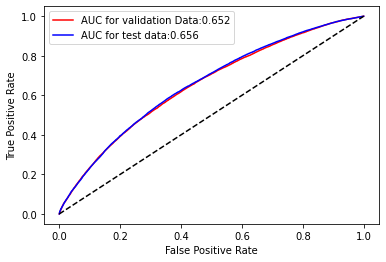

In [30]:
from sklearn.metrics import roc_curve 

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_valid, tpr_valid, 'r-',label ='AUC for validation Data:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'b-',label ='AUC for test data:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Decision Tree Classifier

### fit the model and predict

In [31]:
model2 = DecisionTreeClassifier(max_depth=10)
model2.fit(X_train_sc, y_train)
y_valid_preds = model2.predict_proba(X_valid_sc)[:,1]


In [32]:
print('accuracy on validation data:%.3f'%accuracy_score(y_valid, (y_valid_preds > threshold_value)) )
print("precision on validation data:%.3f "%precision_score(y_valid, (y_valid_preds > threshold_value)) )
print("recall on validation data:%.3f "%recall_score(y_valid, (y_valid_preds > threshold_value)) )
print("f1 on validation data: %.3f"%f1_score(y_valid, (y_valid_preds > threshold_value)) )
print("AUC on validation data: %.3f"%roc_auc_score(y_valid, y_valid_preds ) )

accuracy on validation data:0.653
precision on validation data:0.598 
recall on validation data:0.312 
f1 on validation data: 0.410
AUC on validation data: 0.666


In [33]:
y_test_preds = model2.predict_proba(X_test_sc)[:,1]

In [34]:
print('accuracy on test data:%.3f'%accuracy_score(y_test, (y_test_preds > threshold_value)) )
print("precision on test data:%.3f "%precision_score(y_test, (y_test_preds > threshold_value)) )
print("recall on test data:%.3f "%recall_score(y_test, (y_test_preds > threshold_value)) )
print("f1 on test data: %.3f"%f1_score(y_test, (y_test_preds > threshold_value)) )
print("AUC on test data: %.3f"%roc_auc_score(y_test, y_test_preds ) )

accuracy on test data:0.655
precision on test data:0.595 
recall on test data:0.315 
f1 on test data: 0.412
AUC on test data: 0.664


### Plot ROC curve

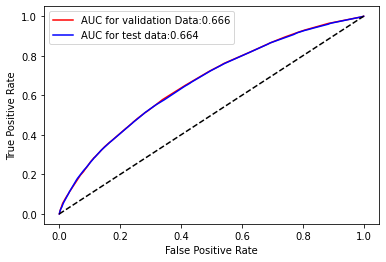

In [35]:
from sklearn.metrics import roc_curve 

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_valid, tpr_valid, 'r-',label ='AUC for validation Data:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'b-',label ='AUC for test data:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Gaussian Naive Bayes

### fit the model and predict

In [36]:
model3 = GaussianNB()
model3.fit(X_train_sc, y_train)
y_valid_preds = model3.predict_proba(X_valid_sc)[:,1]


In [37]:
print('accuracy on validation data:%.3f'%accuracy_score(y_valid, (y_valid_preds > threshold_value)) )
print("precision on validation data:%.3f "%precision_score(y_valid, (y_valid_preds > threshold_value)) )
print("recall on validation data:%.3f "%recall_score(y_valid, (y_valid_preds > threshold_value)) )
print("f1 on validation data: %.3f"%f1_score(y_valid, (y_valid_preds > threshold_value)) )
print("AUC on validation data: %.3f"%roc_auc_score(y_valid, y_valid_preds ) )

accuracy on validation data:0.438
precision on validation data:0.400 
recall on validation data:0.910 
f1 on validation data: 0.556
AUC on validation data: 0.534


In [38]:
y_test_preds = model3.predict_proba(X_test_sc)[:,1]

In [39]:
print('accuracy on test data:%.3f'%accuracy_score(y_test, (y_test_preds > threshold_value)) )
print("precision on test data:%.3f "%precision_score(y_test, (y_test_preds > threshold_value)) )
print("recall on test data:%.3f "%recall_score(y_test, (y_test_preds > threshold_value)) )
print("f1 on test data: %.3f"%f1_score(y_test, (y_test_preds > threshold_value)) )
print("AUC on test data: %.3f"%roc_auc_score(y_test, y_test_preds ) )

accuracy on test data:0.435
precision on test data:0.397 
recall on test data:0.914 
f1 on test data: 0.554
AUC on test data: 0.535


### Plot ROC curve

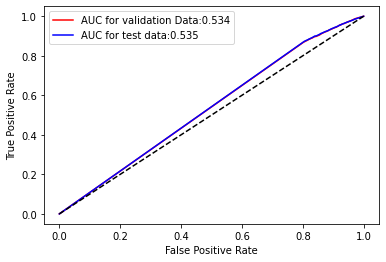

In [40]:
from sklearn.metrics import roc_curve 

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_valid, tpr_valid, 'r-',label ='AUC for validation Data:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'b-',label ='AUC for test data:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## SGDClassifier

### fit the model and predict

In [41]:
model4=SGDClassifier(loss = 'log',alpha = 0.1)
model4.fit(X_train_sc, y_train)
y_valid_preds = model4.predict_proba(X_valid_sc)[:,1]

In [42]:
print('accuracy on validation data:%.3f'%accuracy_score(y_valid, (y_valid_preds > threshold_value)) )
print("precision on validation data:%.3f "%precision_score(y_valid, (y_valid_preds > threshold_value)) )
print("recall on validation data:%.3f "%recall_score(y_valid, (y_valid_preds > threshold_value)) )
print("f1 on validation data: %.3f"%f1_score(y_valid, (y_valid_preds > threshold_value)) )
print("AUC on validation data: %.3f"%roc_auc_score(y_valid, y_valid_preds ) )

accuracy on validation data:0.640
precision on validation data:0.599 
recall on validation data:0.211 
f1 on validation data: 0.312
AUC on validation data: 0.651


In [43]:
y_test_preds = model4.predict_proba(X_test_sc)[:,1]

In [44]:
print('accuracy on test data:%.3f'%accuracy_score(y_test, (y_test_preds > threshold_value)) )
print("precision on test data:%.3f "%precision_score(y_test, (y_test_preds > threshold_value)) )
print("recall on test data:%.3f "%recall_score(y_test, (y_test_preds > threshold_value)) )
print("f1 on test data: %.3f"%f1_score(y_test, (y_test_preds > threshold_value)) )
print("AUC on test data: %.3f"%roc_auc_score(y_test, y_test_preds ) )

accuracy on test data:0.642
precision on test data:0.591 
recall on test data:0.213 
f1 on test data: 0.314
AUC on test data: 0.655


### Plot ROC curve

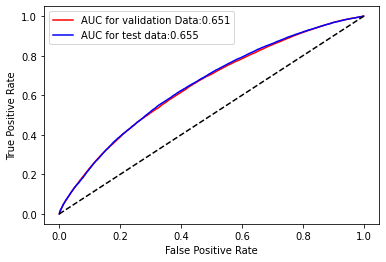

In [45]:
from sklearn.metrics import roc_curve 

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_valid, tpr_valid, 'r-',label ='AUC for validation Data:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'b-',label ='AUC for test data:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Random Forest Classifier

### fit the model and predict

In [46]:
model5=RandomForestClassifier(max_depth = 6)
model5.fit(X_train_sc, y_train)
y_valid_preds = model5.predict_proba(X_valid_sc)[:,1]

In [47]:
print('accuracy on validation data:%.3f'%accuracy_score(y_valid, (y_valid_preds > threshold_value)) )
print("precision on validation data:%.3f "%precision_score(y_valid, (y_valid_preds > threshold_value)) )
print("recall on validation data:%.3f "%recall_score(y_valid, (y_valid_preds > threshold_value)) )
print("f1 on validation data: %.3f"%f1_score(y_valid, (y_valid_preds > threshold_value)) )
print("AUC on validation data: %.3f"%roc_auc_score(y_valid, y_valid_preds ) )

accuracy on validation data:0.616
precision on validation data:0.794 
recall on validation data:0.010 
f1 on validation data: 0.019
AUC on validation data: 0.660


In [48]:
y_test_preds = model5.predict_proba(X_test_sc)[:,1]

In [49]:
print('accuracy on test data:%.3f'%accuracy_score(y_test, (y_test_preds > threshold_value)) )
print("precision on test data:%.3f "%precision_score(y_test, (y_test_preds > threshold_value)) )
print("recall on test data:%.3f "%recall_score(y_test, (y_test_preds > threshold_value)) )
print("f1 on test data: %.3f"%f1_score(y_test, (y_test_preds > threshold_value)) )
print("AUC on test data: %.3f"%roc_auc_score(y_test, y_test_preds ) )

accuracy on test data:0.619
precision on test data:0.786 
recall on test data:0.009 
f1 on test data: 0.018
AUC on test data: 0.660


### Plot ROC curve

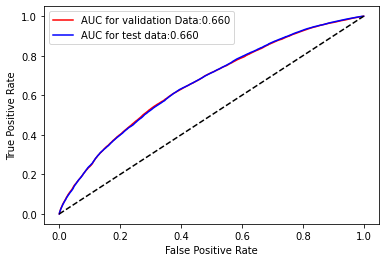

In [50]:
from sklearn.metrics import roc_curve 

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_valid, tpr_valid, 'r-',label ='AUC for validation Data:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'b-',label ='AUC for test data:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Gradient Boosting Classifier

### fit the model and predict

In [51]:
model6 =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)
model6.fit(X_train_sc, y_train)
y_valid_preds = model6.predict_proba(X_valid_sc)[:,1]

In [52]:
print('accuracy on validation data:%.3f'%accuracy_score(y_valid, (y_valid_preds > threshold_value)) )
print("precision on validation data:%.3f "%precision_score(y_valid, (y_valid_preds > threshold_value)) )
print("recall on validation data:%.3f "%recall_score(y_valid, (y_valid_preds > threshold_value)) )
print("f1 on validation data: %.3f"%f1_score(y_valid, (y_valid_preds > threshold_value)) )
print("AUC on validation data: %.3f"%roc_auc_score(y_valid, y_valid_preds ) )

accuracy on validation data:0.659
precision on validation data:0.594 
recall on validation data:0.371 
f1 on validation data: 0.457
AUC on validation data: 0.681


In [53]:
y_test_preds = model6.predict_proba(X_test_sc)[:,1]

In [54]:
print('accuracy on test data:%.3f'%accuracy_score(y_test, (y_test_preds > threshold_value)) )
print("precision on test data:%.3f "%precision_score(y_test, (y_test_preds > threshold_value)) )
print("recall on test data:%.3f "%recall_score(y_test, (y_test_preds > threshold_value)) )
print("f1 on test data: %.3f"%f1_score(y_test, (y_test_preds > threshold_value)) )
print("AUC on test data: %.3f"%roc_auc_score(y_test, y_test_preds ) )

accuracy on test data:0.662
precision on test data:0.593 
recall on test data:0.378 
f1 on test data: 0.462
AUC on test data: 0.685


### Plot ROC curve

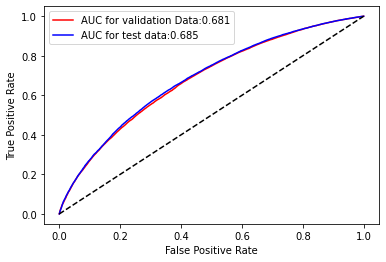

In [55]:
from sklearn.metrics import roc_curve 

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_valid, tpr_valid, 'r-',label ='AUC for validation Data:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'b-',label ='AUC for test data:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# References
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
